In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import numpy as np

import astropy.units as u
import astropy.constants as c

import warnings

from read import read_pbh, output_specs

WDIR = os.environ['DM21CM_DIR']
sys.path.append(WDIR)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps as cms
mpl.rc_file(f"{WDIR}/matplotlibrc")

In [12]:
results_dir = '/n/home07/yitians/dm21cm/blackhawk/BlackHawk_v2.2/results'
run_name = 'm16.000_sec'

run_dir = f"{results_dir}/{run_name}"

In [13]:
evol_data = read_pbh(run_dir, 'evolution')

In [14]:
evol_data['units']

{'M0': Unit("g"),
 'rho_comov': Unit("1 / cm3"),
 't': Unit("s"),
 'dt': Unit("s"),
 'M': Unit("g")}

In [15]:
evol_data.keys()

dict_keys(['M0', 'rho_comov', 't', 'dt', 'M', 'units'])

# 1. Energy loss rates

In [16]:
sec_spec = read_pbh(run_dir, 'secondary', particle='electron')
sec_spec['units']

{'E': Unit("eV"), 't': Unit("s"), 'dN_dEdt': Unit("1 / (eV s)")}

In [17]:
sec_spec.keys()

dict_keys(['E', 't', 'dN_dEdt', 'units'])

In [18]:
def plot_spec(ax, particle, pri_or_sec, i_start=0, **kwargs):
    if particle == 'total':
        sec_spec = read_pbh(run_dir, 'primary', particle='graviton')
        spec_tot_eng = np.trapz(sec_spec['dN_dEdt'] * sec_spec['E'][None, :], x=sec_spec['E'], axis=-1)
        if pri_or_sec == 'primary':
            p_list = [f.split('_')[0] for f in os.listdir('../../../blackhawk/BlackHawk_v2.2/results/m13.200_sec/') if 'primary' in f and 'graviton' not in f]
        else:
            p_list = ['photon', 'electron', 'proton', 'nu_e', 'nu_mu', 'nu_tau']
        for p in p_list:
            sec_spec = read_pbh(run_dir, pri_or_sec, particle=p)
            spec_tot_eng += np.trapz(sec_spec['dN_dEdt'] * sec_spec['E'][None, :], x=sec_spec['E'], axis=-1)
        spec_tot_eng = (spec_tot_eng * u.eV / c.c**2).to('g').value
    else:
        sec_spec = read_pbh(run_dir, pri_or_sec, particle=particle)
        spec_tot_eng = np.trapz(sec_spec['dN_dEdt'] * sec_spec['E'][None, :], x=sec_spec['E'], axis=-1)
        spec_tot_eng = (spec_tot_eng * u.eV / c.c**2).to('g').value
    ax.plot(evol_data['t'][i_start:], spec_tot_eng[i_start:], **kwargs)

In [11]:
[f.split('_')[0] for f in os.listdir('../../../blackhawk/BlackHawk_v2.2/results/m13.200_sec/') if 'primary' in f and 'graviton' not in f]

['strange',
 'down',
 'charm',
 'wpm',
 'higgs',
 'bottom',
 'muon',
 'neutrinos',
 'top',
 'z0',
 'tau',
 'electron',
 'up',
 'photon',
 'gluon']

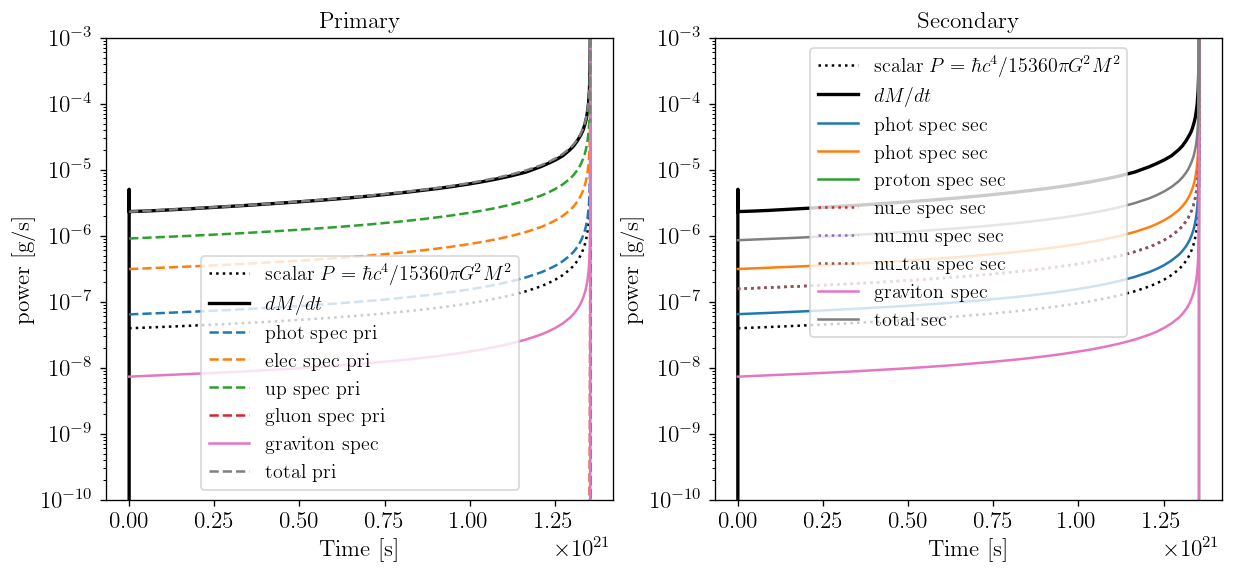

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# theory
power = (c.hbar*c.c**4 / (15360 * np.pi * c.G**2 * evol_data['M']**2 * u.g**2)).to('g/s').value
axs[0].plot(evol_data['t'], power, 'k:', label=r"scalar $P = \hbar c^4 / 15360 \pi G^2 M^2$")
axs[1].plot(evol_data['t'], power, 'k:', label=r"scalar $P = \hbar c^4 / 15360 \pi G^2 M^2$")

# grad(M, t)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    dMdt = np.abs(np.gradient(evol_data['M'], evol_data['t'])) # [g/s]
i_start = np.where(evol_data['t'] > 1e10)[0][0] # [s]
axs[0].plot(evol_data['t'][i_start:], dMdt[i_start:], color='k', label=r'$dM/dt$', lw=2)
axs[1].plot(evol_data['t'][i_start:], dMdt[i_start:], color='k', label=r'$dM/dt$', lw=2)

# primary spectrum
ax = axs[0]
plot_spec(ax, 'photon', 'primary', i_start=i_start, color='C0', ls='--', label='phot spec pri')
plot_spec(ax, 'electron', 'primary', i_start=i_start, color='C1', ls='--', label='elec spec pri')
plot_spec(ax, 'up', 'primary', i_start=i_start, color='C2', ls='--', label='up spec pri')
plot_spec(ax, 'gluon', 'primary', i_start=i_start, color='C3', ls='--', label='gluon spec pri')
plot_spec(ax, 'graviton', 'primary', i_start=i_start, color='C6', ls='-', label='graviton spec')

plot_spec(ax, 'total', 'primary', i_start=i_start, color='C7', ls='--', label='total pri')

# secondary spectrum
ax = axs[1]
plot_spec(ax, 'photon', 'secondary', i_start=i_start, color='C0', ls='-', label='phot spec sec')
plot_spec(ax, 'electron', 'secondary', i_start=i_start, color='C1', ls='-', label='phot spec sec')

plot_spec(ax, 'proton', 'secondary', i_start=i_start, color='C2', ls='-', label='proton spec sec')
plot_spec(ax, 'nu_e', 'secondary', i_start=i_start, color='C3', ls=':', label='nu_e spec sec')
plot_spec(ax, 'nu_mu', 'secondary', i_start=i_start, color='C4', ls=':', label='nu_mu spec sec')
plot_spec(ax, 'nu_tau', 'secondary', i_start=i_start, color='C5', ls=':', label='nu_tau spec sec')
plot_spec(ax, 'graviton', 'primary', i_start=i_start, color='C6', ls='-', label='graviton spec')

plot_spec(ax, 'total', 'secondary', i_start=i_start, color='C7', ls='-', label='total sec')

# plotting
axs[0].set(yscale='log', xlabel='Time [s]', ylabel='power [g/s]', title='Primary')
axs[0].set(ylim=(1e-10, 1e-3))
axs[0].legend()

axs[1].set(yscale='log', xlabel='Time [s]', ylabel='power [g/s]', title='Secondary')
axs[1].set(ylim=(1e-10, 1e-3))
axs[1].legend()

In [5]:
from dm21cm.utils import load_h5_dict

In [6]:
data_dir = f'{WDIR}/data/pbh'
m_PBH = 10**13.2
data = load_h5_dict(f'{data_dir}/pbh_logm{np.log10(m_PBH):.3f}.h5')

In [8]:
data.keys()

dict_keys(['elec dNdEdt', 'phot dNdEdt', 't', 'units'])

# Conservation in DH evolution

In [28]:
sys.path.append(os.environ['DH_DIR'])
import darkhistory.physics as phys

from scipy import interpolate
from astropy.cosmology import Planck18 as cosmo

In [30]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    dMdt = np.abs(np.gradient(evol_data['M'], evol_data['t'])) # [g/s]
i_start = np.where(evol_data['t'] > 1e10)[0][0] # [s]

evol_data['t'][i_start:], dMdt[i_start:]

dMdt_t = interpolate.interp1d(evol_data['t'][i_start:], dMdt[i_start:], kind='linear', fill_value=0, bounds_error=False)

In [41]:
start_rs = 3000
end_rs = 4
coarsen_factor = 1

dlnz = 0.001

rs_s = []
dt_s = []
dM_s = []

rs = start_rs
while rs > end_rs: # darkhistory loop
    dt = dlnz * coarsen_factor / phys.hubble(rs)
    t = cosmo.age(rs-1).to(u.s).value # [s]
    dM = dMdt_t(t) * dt

    rs_s.append(rs)
    dt_s.append(dt)
    dM_s.append(dM)

    rs = np.exp(np.log(rs) - dlnz * coarsen_factor) # next_rs

In [ ]:
plt.plot(rs_s, dM_s)

In [40]:
np.sum(dM_s) / evol_data['M0']

0.4315711884275884

# Archive

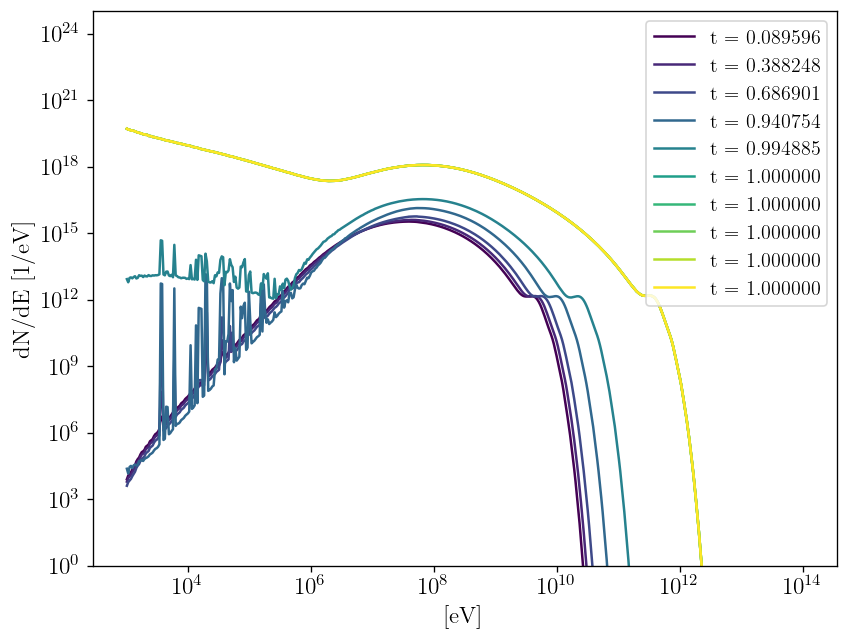

In [71]:
i_show_s = [120, 130, 140, 150, 160, 200, 300, 400, 600, 688]

spec = read_pbh(run_dir, 'secondary', particle='photon')
dNdE_interp = interpolate.interp1d(spec['t'], spec['dN_dEdt'], axis=0)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

for i, i_show in enumerate(i_show_s):
    t = sec_spec['t'][i_show]
    color = cms['viridis'](i/(len(i_show_s) - 1))
    tf = sec_spec['t'][-1]
    dNdE = dNdE_interp(t)
    ax.plot(spec['E'], dNdE, color=color, label=f't = {t/tf:.6f}')
ax.set(xscale='log', yscale='log')
ax.set(ylim=(1e0, 1e25))
ax.set(xlabel='[eV]', ylabel='dN/dE [1/eV]')
ax.legend()

In [74]:
spec['E'].shape

(1000,)

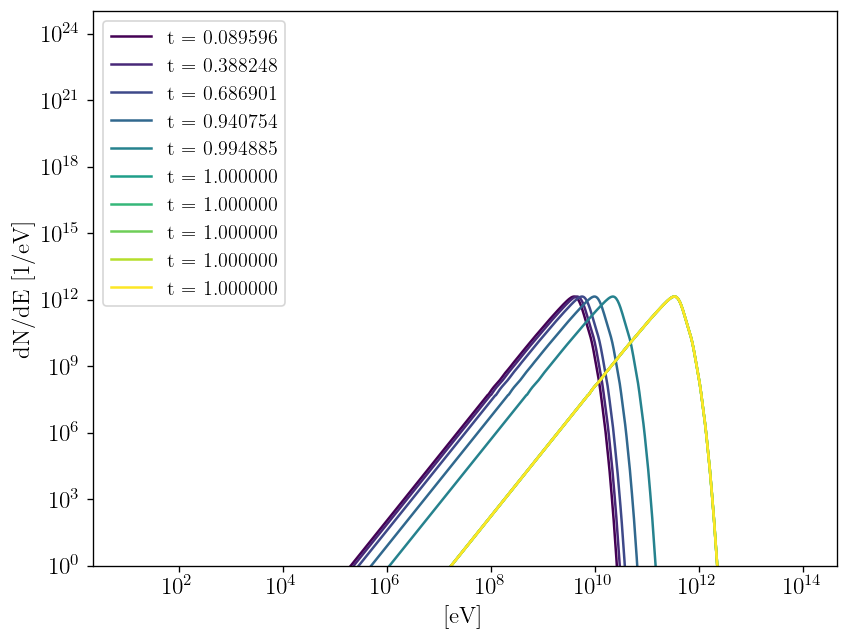

In [75]:
i_show_s = [120, 130, 140, 150, 160, 200, 300, 400, 600, 688]

spec = read_pbh(run_dir, 'primary', particle='photon')
dNdE_interp = interpolate.interp1d(spec['t'], spec['dN_dEdt'], axis=0)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

for i, i_show in enumerate(i_show_s):
    t = sec_spec['t'][i_show]
    color = cms['viridis'](i/(len(i_show_s) - 1))
    tf = sec_spec['t'][-1]
    dNdE = dNdE_interp(t)
    ax.plot(spec['E'], dNdE, color=color, label=f't = {t/tf:.6f}')
ax.set(xscale='log', yscale='log')
ax.set(ylim=(1e0, 1e25))
ax.set(xlabel='[eV]', ylabel='dN/dE [1/eV]')
ax.legend()